### References
https://github.com/igor-sokolov/dataminingcapstone/blob/master/Capstone%20project%202.ipynb
https://github.com/l0neJT/uoi-coursera-data-mining/blob/master/capstone/task02-cuisine-map.ipynb
https://github.com/ducthienbui97/DataMiningCapstone/tree/master/Notebooks
https://pandas.pydata.org/docs/reference/api
https://gemini.google.com/

In [1]:
!wget https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
!tar -xvf /kaggle/working/yelp_dataset.tar.gz

--2024-04-09 12:45:00--  https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
Resolving d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)... 13.35.159.211, 13.35.159.89, 13.35.159.60, ...
Connecting to d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)|13.35.159.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443445047 (423M) [application/x-gzip]
Saving to: 'yelp_dataset.tar.gz'

yelp_dataset.tar.gz 100%[===================>] 422.90M  53.2MB/s    in 8.5s    

2024-04-09 12:45:09 (50.0 MB/s) - 'yelp_dataset.tar.gz' saved [443445047/443445047]

yelp_dataset_challenge_academic_dataset/
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json
yelp_dataset_challenge_academic_dataset/Dataset_Challenge_Academic_Dataset_Agreement.pdf
yelp_datase

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [3]:
uri = '/kaggle/working/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json'
business_df = pd.read_json(uri, lines=True)


## Preprocessing:
- extract the reviews involved with "Restaurant"
- remove useless tags: "Food", "Restaurant"

In [4]:
# restaurant_df
restaurant_df = business_df[business_df['categories'].apply(lambda cat: "Restaurants" in cat)]

# remove useless tags
def remove_food(cat):
    if 'Food' in cat:
        return cat.remove('Food')
    else:
        return cat
    
# cuisine_df
restaurant_df.categories.apply(lambda cats: cats.remove("Restaurants"))
restaurant_df['categories'] = restaurant_df['categories'].apply(remove_food)


/tmp/ipykernel_18/2055587074.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['categories'] = restaurant_df['categories'].apply(remove_food)


In [5]:
# extract business_id & cat to cuisine_df
cuisine_df = restaurant_df[['business_id', 'categories']]
cuisine_df.head()

,business_id,categories
1,JwUE5GmEO-sH1FuwJgKBlQ,[]
2,uGykseHzyS5xAMWoN6YUqA,[American (Traditional)]
3,LRKJF43s9-3jG9Lgx4zODg,None
4,RgDg-k9S5YD_BaxMckifkg,[Chinese]
8,rdAdANPNOcvUtoFgcaY9KA,[American (Traditional)]


## Select top 30 catogories

In [6]:
top_cuisines_df = cuisine_df['categories'].explode().value_counts().sort_values(ascending=False).reset_index(name='count')
top_cuisines_df = top_cuisines_df.head(30)

## Reviews_data

In [7]:
REVIEW_SOURCE = "/kaggle/working/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json"
# with open(REVIEW_SOURCE) as f:
#     reviews_df = pd.DataFrame(json.loads(l) for l in f)
reviews_df = pd.read_json(REVIEW_SOURCE, lines=True)


In [8]:
cui_rev_df = cuisine_df.merge(reviews_df, on='business_id')


In [9]:
cui_rev_df = cui_rev_df[['business_id', 'text', 'categories']]

In [10]:
cui_rev_df.set_index('business_id')

,text,categories
business_id,,
JwUE5GmEO-sH1FuwJgKBlQ,Pretty good dinner with a nice selection of fo...,[]
JwUE5GmEO-sH1FuwJgKBlQ,Good truck stop dining at the right price. We ...,[]
JwUE5GmEO-sH1FuwJgKBlQ,"If you like lot lizards, you'll love the Pine ...",[]
JwUE5GmEO-sH1FuwJgKBlQ,Enjoyable experience for the whole family. The...,[]
JwUE5GmEO-sH1FuwJgKBlQ,One of my favorite truck stop diners with soli...,[]
...,...,...
uUsfpN81JCMKyH6c0D0bTg,Ive never had bad pizza or pasta here. Very a...,None
uUsfpN81JCMKyH6c0D0bTg,3.5 stars.\n\nTried this place for dinner and ...,None
BMjggIgOghBMEXPo8q7q3w,My new favorite restaurant. They have 22 diff...,"[Kosher, Italian, Pizza]"


In [11]:
cui_rev_exploded = cui_rev_df.explode('categories')
cui_rev_exploded.categories.value_counts()

categories
Nightlife                 83222
American (New)            81807
American (Traditional)    78568
Bars                      78383
Mexican                   69024
                          ...  
Home Services                 1
Real Estate                   1
Apartments                    1
Mass Media                    1
Print Media                   1
Name: count, Length: 199, dtype: int64

In [12]:
cui_rev_exploded = cui_rev_exploded.dropna(subset=['categories'])


In [13]:
merged_df = top_cuisines_df.merge(cui_rev_exploded, how='left', on='categories')


### group by categories and text

In [14]:
merged_df['combined_text'] = merged_df.groupby('categories')['text'].transform(lambda x: ', '.join(x.dropna()))
merged_df.drop_duplicates(subset=['categories'], inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 1028276
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   categories     30 non-null     object
 1   count          30 non-null     int64 
 2   business_id    30 non-null     object
 3   text           30 non-null     object
 4   combined_text  30 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.4+ KB


In [15]:
top_merged_df = merged_df.sort_values(by='count', ascending=False)

In [16]:
combined_text_lst = merged_df['combined_text'].tolist()

## Computing similarities

In [17]:
# helper func
def mx2corr(mx):
    df = pd.DataFrame(mx, columns=merged_df['categories'].tolist())

    return df.corr()


In [18]:

cnt_vectorizer = CountVectorizer(stop_words='english')
idf_vectorizer = TfidfVectorizer(stop_words='english')

cnt_mx = cnt_vectorizer.fit_transform(combined_text_lst)
idf_mx = idf_vectorizer.fit_transform(combined_text_lst)


cnt_cos = cosine_similarity(cnt_mx, cnt_mx)
idf_cos = cosine_similarity(idf_mx, idf_mx)

cnt_cos_df = pd.DataFrame(cnt_cos, columns=top_merged_df['categories'], index=top_merged_df['categories'])
idf_cos_df = pd.DataFrame(idf_cos, columns=top_merged_df['categories'], index=top_merged_df['categories'])

<Axes: xlabel='categories', ylabel='categories'>

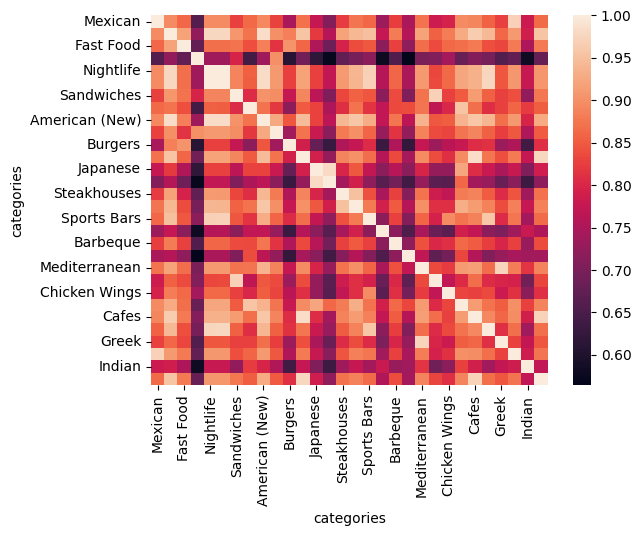

In [19]:
sns.heatmap(cnt_cos_df)

<Axes: xlabel='categories', ylabel='categories'>

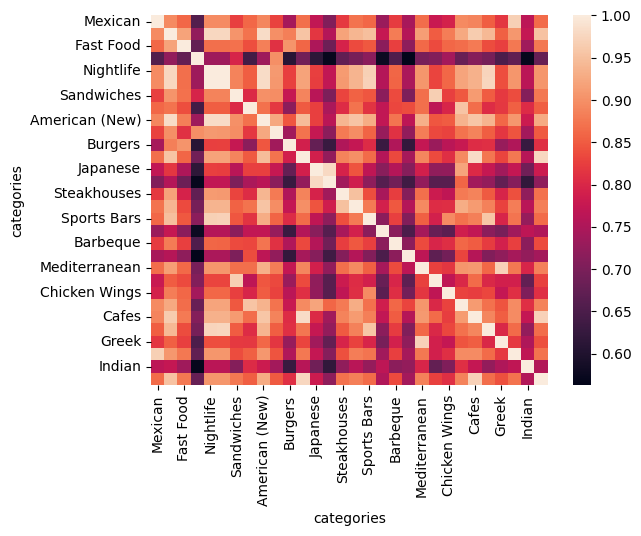

In [20]:
sns.heatmap(idf_cos_df)

## Findings:
+ easy to find the similarities of different items.
+ difficult to compare tf-idf and idf features,
+ difficult to do cluster analysis.

## K-mean to cluster

https://datascience.stackexchange.com/questions/87792/how-do-i-calculate-distance-of-test-data-point-from-centroids-in-kmeans-scikit-l

+ make the distance between data point and the centroid point of the second point as the similarity 

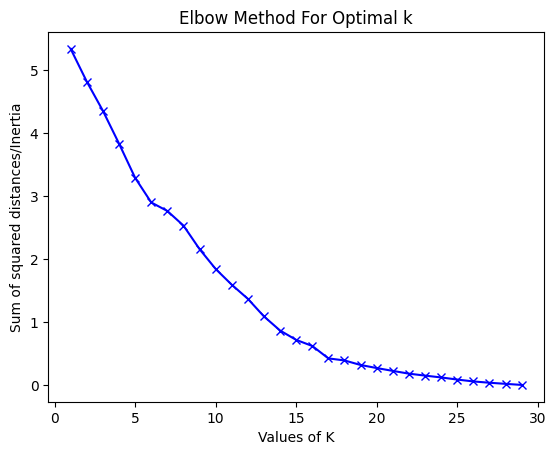

In [21]:
Sum_of_squared_distances = []
K = range(1,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=1875, n_init="auto", max_iter=10000)
    kmeans.fit(idf_mx)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

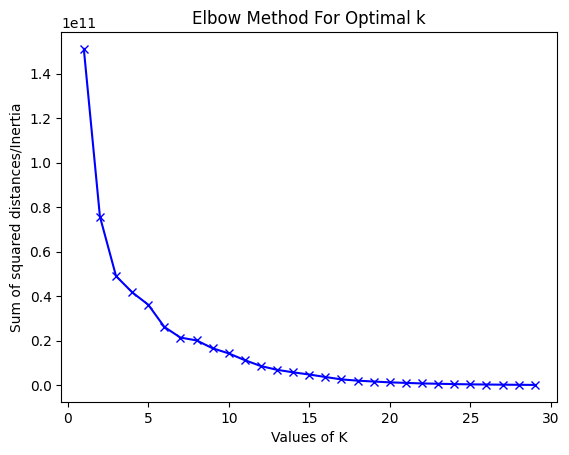

In [22]:
Sum_of_squared_distances = []
K = range(1,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=1875, n_init="auto", max_iter=10000)
    kmeans.fit(cnt_mx)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

### K_cnt = 7, K_idf = 17 based on the graph above

In [23]:
# k-mean
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

k_cnt = 7
k_idf = 17

cnt_kmeans = KMeans(n_clusters=k_cnt, random_state=1875, n_init="auto").fit(cnt_mx)
idf_kmeans = KMeans(n_clusters=k_idf, random_state=1875, n_init="auto").fit(idf_mx)



In [24]:
cnt_labs = cnt_kmeans.labels_
idf_labs = idf_kmeans.labels_

cnt_centroids = cnt_kmeans.cluster_centers_
idf_centroids = idf_kmeans.cluster_centers_



In [25]:
top_merged_df['cnt_labels'] = cnt_labs
top_merged_df['idf_labels'] = idf_labs

In [26]:
cnt_centroids_df = pd.DataFrame(cnt_centroids).T
idf_centroids_df = pd.DataFrame(idf_centroids).T

cnt_centroids_df.columns = ['cluster'+str(i) for i in range(k_cnt)]
idf_centroids_df.columns = ['cluster'+str(i) for i in range(k_idf)]


In [27]:
top_merged_df['cnt_centroids'] = top_merged_df['cnt_labels'].apply(
    lambda x: cnt_centroids_df['cluster'+str(x)].values
)

top_merged_df['idf_centroids'] = top_merged_df['idf_labels'].apply(
    lambda x: idf_centroids_df['cluster'+str(x)].values
)

In [28]:
top_merged_df.set_index(top_merged_df.categories, inplace=True)


In [29]:
cnt_centroids_lst = top_merged_df['cnt_centroids'].tolist()
idf_centroids_lst = top_merged_df['idf_centroids'].tolist()


In [30]:
cnt_centroids_mx = np.stack(cnt_centroids_lst)
idf_centroids_mx = np.stack(idf_centroids_lst)


In [31]:
from sklearn.metrics.pairwise import euclidean_distances

cnt_dis2cent_df = pd.DataFrame(euclidean_distances(cnt_mx.toarray(), cnt_centroids_mx), \
                               columns = top_merged_df['categories'], \
                               index=top_merged_df['categories']).T

idf_dis2cent_df = pd.DataFrame(euclidean_distances(idf_mx.toarray(), idf_centroids_mx), \
                               columns = top_merged_df['categories'], \
                               index=top_merged_df['categories']).T


In [32]:
idf_vis_df = idf_dis2cent_df
# Iterate over columns and modify values
for column_name, series in idf_vis_df.items():
    maximum = series.max()
    idf_vis_df[column_name] = series / maximum

for i in range(len(idf_vis_df)):
    standard = idf_vis_df.iloc[i,i]
    
    idf_vis_df.iloc[:, i] = 1 - abs(standard - idf_vis_df.iloc[:, i])
    
# sns.heatmap(idf_vis_df)

In [33]:
cnt_vis_df = cnt_dis2cent_df
# Iterate over columns and modify values
for column_name, series in cnt_vis_df.items():
    maximum = series.max()
    cnt_vis_df[column_name] = series / maximum

for i in range(len(cnt_vis_df)):
    standard = cnt_vis_df.iloc[i,i]
    
    cnt_vis_df.iloc[:, i] = 1 - abs(standard - cnt_vis_df.iloc[:, i])

# sns.heatmap(cnt_vis_df)

In [34]:
idf_vis_df['cluster'] = top_merged_df.idf_labels
cnt_vis_df['cluster'] = top_merged_df.cnt_labels

cnt_vis_df.sort_values(by='cluster', inplace=True)
idf_vis_df.sort_values(by='cluster', inplace=True)
cnt_vis_df.drop('cluster', axis=1, inplace=True)
idf_vis_df.drop('cluster', axis=1, inplace=True)

idf_vis_df = idf_vis_df.reindex(columns=idf_vis_df.index.tolist())
cnt_vis_df = cnt_vis_df.reindex(columns=cnt_vis_df.index.tolist())

<Axes: xlabel='categories', ylabel='categories'>

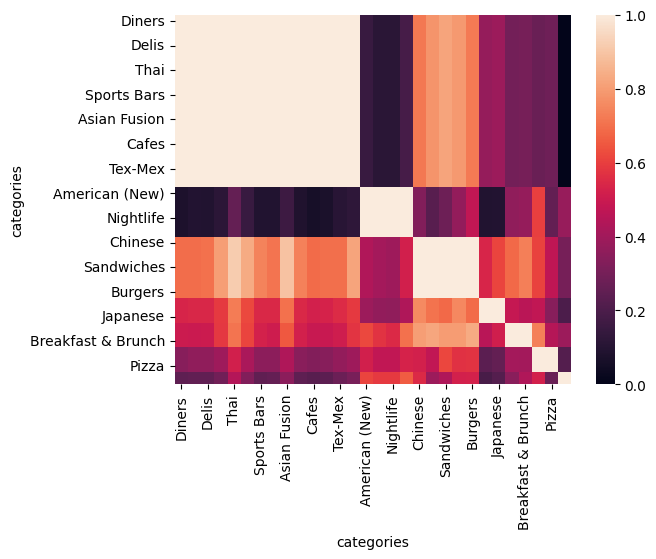

In [35]:
sns.heatmap(cnt_vis_df)

0->2->3->4->5->1

<Axes: xlabel='categories', ylabel='categories'>

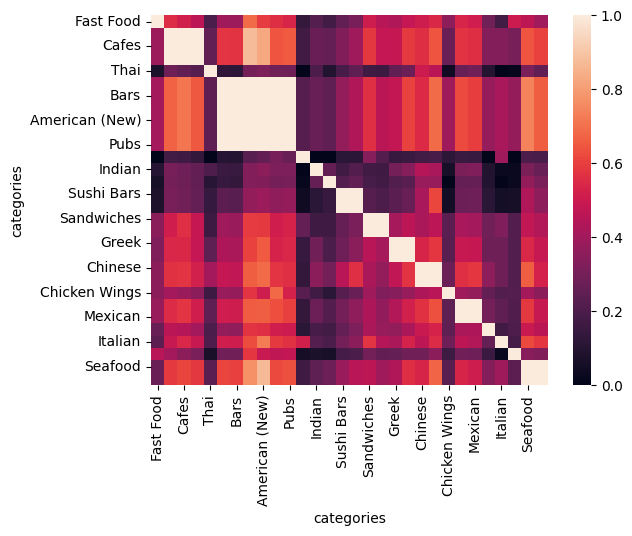

In [36]:
sns.heatmap(idf_vis_df)

### Findings:
+ TF-IDF is more efficient than TF only.
+ easy to do cluster analysis. e.g: cnt_clusters analysis:
0->2->3->4->5->1